In [1]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde

In [15]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
sys.path.append('../src')
import LocusTools as lt
import PlotTools as pt

In [325]:
## TRILEGAL sims: file from Dani three_pix_triout.dat
trilegal = lt.readTRILEGAL()

reading from default file: ../data/three_pix_triout.dat


In [350]:
## definition of Mr from TRILEGAL quantities
trilegal['Mr'] = trilegal['rmag'] - trilegal['Ar'] - trilegal['DM']  
# save original TRILEGAL colors 
trilegal['ugTLorig'] = trilegal['ug']
trilegal['grTLorig'] = trilegal['gr']
trilegal['riTLorig'] = trilegal['ri']
trilegal['izTLorig'] = trilegal['iz']
trilegal['giTLorig'] = trilegal['gi']
# and magnitudes
for b in ['u', 'g', 'r', 'i', 'z']:  
    trilegal[b+'magTLorig'] = trilegal[b+'mag']

## and this is a hack to "fix" TRILEGAL [Fe/H] distribution to be more similar to SDSS measurements
if (1):
    # shift thin disk stars to lower [Fe/H] by 0.3 dex
    trilegal['FeH'] = np.where(trilegal['comp']==1, trilegal['FeH']-0.3, trilegal['FeH'])
    # shift halo stars to higher [Fe/H] by 0.1 dex
    trilegal['FeH'] = np.where(trilegal['comp']==3, trilegal['FeH']+0.1, trilegal['FeH'])

In [351]:
## show Galactic component the star belongs to: 
##   1 → thin disk; 2 → thick disk; 3 → halo; 4 → bulge; 5 → Magellanic Clouds.
kk = trilegal['comp']
t = {}
for i in range(1,5):
    t[i] = trilegal[kk==i]
    print(i, np.size(t[i]))

1 812467
2 171778
3 301992
4 6235


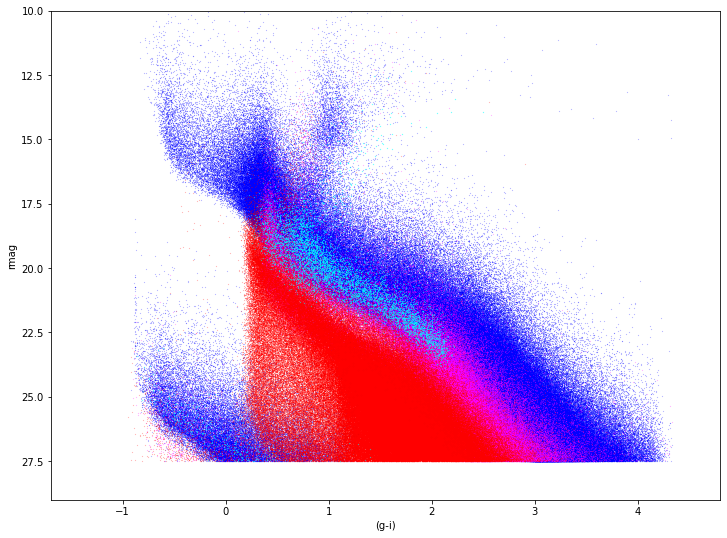

In [352]:
# Galactic components: 
fig,ax = plt.subplots(1,1,figsize=(12,9))
C1 = 'giTLorig'
C2 = 'rmagTLorig'

ax.set_xlim(-1.7,4.8)
ax.set_ylim(29,10) 

ax.set_xlabel('(g-i)')
ax.set_ylabel('rmag')

ax.scatter(t[1][C1], t[1][C2], s=0.01, c='blue')
ax.scatter(t[2][C1], t[2][C2], s=0.01, c='magenta')
ax.scatter(t[3][C1], t[3][C2], s=0.01, c='red')
ax.scatter(t[4][C1], t[4][C2], s=0.05, c='cyan')

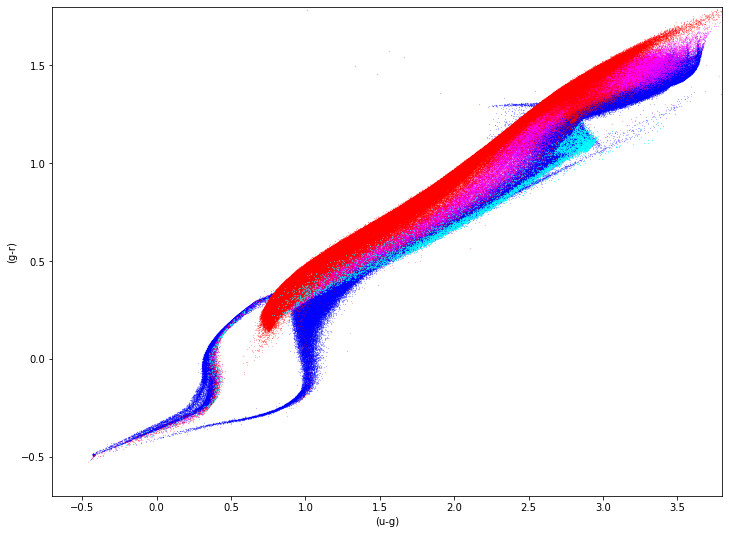

In [353]:
fig,ax = plt.subplots(1,1,figsize=(12,9))
C1 = 'ugTLorig'
C2 = 'grTLorig'

ax.set_xlim(-0.7,3.8)
ax.set_ylim(-0.7,1.8) 

ax.set_xlabel('(u-g)')
ax.set_ylabel('(g-r)')

ax.scatter(t[1][C1], t[1][C2], s=0.01, c='blue')
ax.scatter(t[2][C1], t[2][C2], s=0.01, c='magenta')
ax.scatter(t[3][C1], t[3][C2], s=0.01, c='red')
ax.scatter(t[4][C1], t[4][C2], s=0.05, c='cyan')

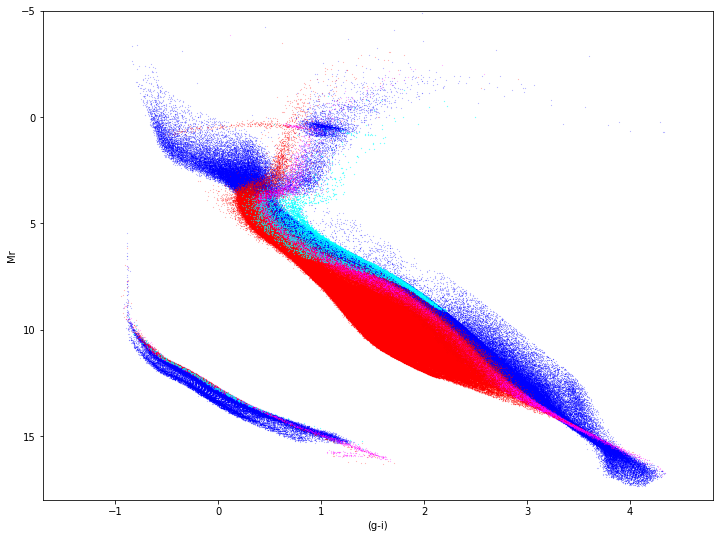

In [354]:
# Galactic components: 
fig,ax = plt.subplots(1,1,figsize=(12,9))
C1 = 'giTLorig'
C2 = 'Mr'

ax.set_xlim(-1.7,4.8)
ax.set_ylim(18,-5) 

ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(t[1][C1], t[1][C2], s=0.01, c='blue')
ax.scatter(t[2][C1], t[2][C2], s=0.01, c='magenta')
ax.scatter(t[3][C1], t[3][C2], s=0.01, c='red')
ax.scatter(t[4][C1], t[4][C2], s=0.05, c='cyan')

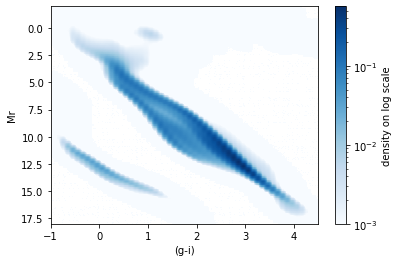

In [355]:
pt.plot2Dmap(trilegal['giTLorig'], trilegal['Mr'], -1.0, 4.5, 55, 18.0, -2, 100, '(g-i)', 'Mr', addMedians=False, logScale=True)

## a few more sanity plots and a comparison to SDSS locus parametrization (MS & RG)

In [356]:
LSSTlocus = lt.LSSTsimsLocus(fixForStripe82=False)

In [378]:
### select TRILEGAL stars from limited color range (and get rid of white dwarfs)
giMin = 0.2
giMax = 3.6   # stars redder than g-i=3.0 are hopelessly faint in the u band
#giMax = 3.0   # stars redder than g-i=3.0 are hopelessly faint in the u band
tGood = trilegal[(trilegal['giTLorig']>giMin)&(trilegal['giTLorig']<giMax)&(trilegal['logg']<7.0)]
print(np.size(tGood), np.size(tGood)/np.size(trilegal))  # 95% of all stars are still selected

1228065 0.9501675858355152


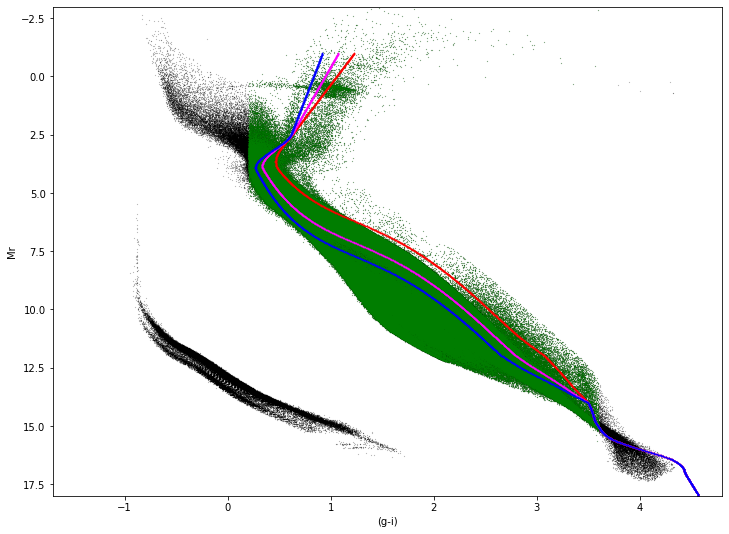

In [379]:
# compare selected stars to the full sample
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(-1.7,4.8)
ax.set_ylim(18,-3) 
ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(trilegal['giTLorig'], trilegal['Mr'], s=0.01, c='black') 
ax.scatter(tGood['giTLorig'], tGood['Mr'], s=0.01, c='green') 

## selecting a few LSSTlocus tracks at fixed metallicity
FeH0 =  0.0
FeH1 = -1.0
FeH2 = -2.0
LSSTlocus0 = LSSTlocus[(LSSTlocus['FeH']>FeH0-0.01)&(LSSTlocus['FeH']<FeH0+0.01)]
LSSTlocus1 = LSSTlocus[(LSSTlocus['FeH']>FeH1-0.01)&(LSSTlocus['FeH']<FeH1+0.01)]
LSSTlocus2 = LSSTlocus[(LSSTlocus['FeH']>FeH2-0.01)&(LSSTlocus['FeH']<FeH2+0.01)]
ax.scatter(LSSTlocus0['gi'], LSSTlocus0['Mr'], s=0.3, c='red')
ax.scatter(LSSTlocus1['gi'], LSSTlocus1['Mr'], s=0.3, c='magenta')
ax.scatter(LSSTlocus2['gi'], LSSTlocus2['Mr'], s=0.3, c='blue')

## Generate simulated "observed" photometry with uncertainties
#### original magnitudes and colors from TRILEGAL have suffix "TLorig" (umagTL, ugTL...)
#### re-generated mags and colors using SDSS stellar locus, and without noise, have suffix "SL" 
#### "observed" versions will have suffix Obs (including re-generated errors, see 6 below)

In [380]:
### all good so far, now: 
## 1) given rmag, Ar and DM, generate Mr 
## 2) with FeH and Mr, generate colors 
## 3) with original r magnitude, generate other magnitudes from colors
## 4) given magnitudes, generate errors for LSST
## 5) generate observed mags
## 6) regenerate "observed" errors from "observed" magnitudes
## 7) store in a data file 

In [381]:
## 1) already done above

In [382]:
## 2) actual call to get colors (5ms with fast version)
# limit FeH and Mr to values supported by LSSTlocus
FeHmin = -2.50
FeHmax = 0.0 
MrRGcut = -1.0
# apply FeH and Mr cuts above: 
tGoodOK = tGood[(tGood['FeH']>FeHmin)&(tGood['FeH']<FeHmax)&(tGood['Mr']>MrRGcut)]
# note that FeH<0 cut removes about 8% of all (mostly disk) stars 
print(np.size(tGoodOK), np.size(tGoodOK)/np.size(tGood))
## actual call to get (dust-free) colors for each star in tGoodOK (5ms with fast version)
lt.getColorsFromMrFeH(LSSTlocus, tGoodOK)
# let's rename them (and suffix 0 since they don't have dust reddening) 
tGoodOK['ugSL0'] = tGoodOK['ug']
tGoodOK['grSL0'] = tGoodOK['gr']
tGoodOK['riSL0'] = tGoodOK['ri']
tGoodOK['izSL0'] = tGoodOK['iz'] 
tGoodOK['giSL0'] = tGoodOK['grSL0'] + tGoodOK['riSL0']

1129985 0.9201345205669081


In [383]:
## tGoodOK['ug0'] etc. are dust-free colors, now add reddening using Ar along the sightline from TRILEGAL 
## and standard extinction coefficients (from Berry+2012)
# first setup of dust extinction in each band
C = lt.extcoeff()
for b in ['u', 'g', 'i', 'z']:  
    tGoodOK['A'+b] = C[b]*tGoodOK['Ar']  
# and now redden input colors (from stellar locus)
tGoodOK['ugSL'] = tGoodOK['ugSL0'] + tGoodOK['Au'] - tGoodOK['Ag'] 
tGoodOK['grSL'] = tGoodOK['grSL0'] + tGoodOK['Ag'] - tGoodOK['Ar'] 
tGoodOK['riSL'] = tGoodOK['riSL0'] + tGoodOK['Ar'] - tGoodOK['Ai'] 
tGoodOK['izSL'] = tGoodOK['izSL0'] + tGoodOK['Ai'] - tGoodOK['Az'] 

In [384]:
# LSST-motivated faint limit for the output catalog (removes faint stars, ~28%)
rmagMax = 26.0 
tGood4sims = tGoodOK[(tGoodOK['giSL0']>giMin)&(tGoodOK['giSL0']<giMax)&(tGoodOK['ugSL0']>-1)&(tGoodOK['rmagTLorig']<rmagMax)]
print(np.size(tGood4sims), np.size(tGood4sims)/np.size(tGoodOK))

814450 0.7207617800236287


In [385]:
## 3) simulated (noise-free) magnitudes, anchored to TRILEGAL's original r band magnitude: tGood4sims['rmag']
#      note that colors 0 (e.g. tGood4sims['gr']) are DUST-FREE COLORS generated in lt.getColorsFromMrFeH,
#      while colors/magnitudes without "0" include dust reddening
#      tGood4sims['rmag'] comes directly from TRILEGAL (and it includes dust extinction) 
# other magnitudes with ISM extinction accounted for
tGood4sims['rmagSL'] = tGood4sims['rmagTLorig']
tGood4sims['gmagSL'] = tGood4sims['rmagSL'] + tGood4sims['grSL']
tGood4sims['umagSL'] = tGood4sims['gmagSL'] + tGood4sims['ugSL']
tGood4sims['imagSL'] = tGood4sims['rmagSL'] - tGood4sims['riSL']
tGood4sims['zmagSL'] = tGood4sims['imagSL'] - tGood4sims['izSL']

In [386]:
## 4) generate errors expected for LSST coadded depth (per Bianco+2022 paper)
#        note: errors are generated using true dust-extincted magnitudes generated in 3
errorsTrue = lt.getLSSTm5(tGood4sims, depth='coadd', magVersion=True, suffix='SL')

In [387]:
## 5) generate observed mags (by drawing random gaussian noise with mag-dependent std)
ObsMag = {}
for b in ['u', 'g', 'r', 'i', 'z']:  
    tGood4sims[b+'magErrSL'] = errorsTrue[b]
    noise = np.random.normal(0, tGood4sims[b+'magErrSL'])   
    # this is a hack to prevent super faint stars ending up very bright
    minErr = np.where(np.abs(noise)>1, 1, noise)
    # adding noise to true noise-free dust-extincted magnitudes
    tGood4sims[b+'magObs'] = tGood4sims[b+'magSL'] + minErr
    ObsMag[b] = tGood4sims[b+'magObs'] 

In [388]:
# errors for "SL" colors
tGood4sims['ugErrSL'] = np.sqrt(tGood4sims['umagErrSL']**2 + tGood4sims['gmagErrSL']**2)
tGood4sims['grErrSL'] = np.sqrt(tGood4sims['gmagErrSL']**2 + tGood4sims['rmagErrSL']**2)
tGood4sims['riErrSL'] = np.sqrt(tGood4sims['rmagErrSL']**2 + tGood4sims['imagErrSL']**2)
tGood4sims['izErrSL'] = np.sqrt(tGood4sims['imagErrSL']**2 + tGood4sims['zmagErrSL']**2)

In [389]:
# now get errors derived from "observed" magnitudes
#   IMPORTANT: errors are NOT generated using original noise-free magnitudes
ObsMagErr = lt.getLSSTm5err(ObsMag)
for b in ['u', 'g', 'r', 'i', 'z']:  
    tGood4sims[b+'magErrObs'] = ObsMagErr[b]  

In [390]:
# test chi2 behavior for observed magnitudes
for b in ['u', 'g', 'r', 'i', 'z']:   
    chi = (tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrSL'] 
    chiB = chi[ObsMag[b] < 20]
    print('   band:', b, 'chi2dof=', np.std(chiB), np.std(chi))
    chi = (tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrObs']  
    chiB = chi[ObsMag[b] < 20]
    print('trueErr:', b, 'chi2dof=', np.std(chiB), np.std(chi))

   band: u chi2dof= 1.0048991560055518 0.6898931073721073
trueErr: u chi2dof= 1.004899066932134 0.7288364789095144
   band: g chi2dof= 1.0011408621868252 0.9997223057763573
trueErr: g chi2dof= 1.0011413601785977 1.039290461441933
   band: r chi2dof= 0.998375200303325 0.999207108634071
trueErr: r chi2dof= 0.9983756653197973 1.0016886151039857
   band: i chi2dof= 1.0006809583232796 0.9996298984929576
trueErr: i chi2dof= 1.0006821733419833 1.000440561697722
   band: z chi2dof= 0.9978272190375616 1.0004443198121218
trueErr: z chi2dof= 0.9978295779215256 1.0018376159350897


In [391]:
chi2 = 0*ObsMagErr['u']
for b in ['u', 'g', 'r', 'i', 'z']:   
    chi2 = chi2 + ((tGood4sims[b+'magObs'] - tGood4sims[b+'magSL'])/tGood4sims[b+'magErrSL'])**2 
chi2B = chi2[ObsMag['u']<20]
print('  mean, median:', np.mean(chi2)/5, np.median(chi2)/5)
print('B mean, median:', np.mean(chi2B)/5, np.median(chi2B)/5)

  mean, median: 0.8987090683718792 0.7698582954721376
B mean, median: 1.0030532774562553 0.8701211149767474


In [392]:
# generate observed colors (with and without dust extinction)
tGood4sims['ugObs'] = tGood4sims['umagObs'] - tGood4sims['gmagObs'] 
tGood4sims['grObs'] = tGood4sims['gmagObs'] - tGood4sims['rmagObs'] 
tGood4sims['riObs'] = tGood4sims['rmagObs'] - tGood4sims['imagObs'] 
tGood4sims['izObs'] = tGood4sims['imagObs'] - tGood4sims['zmagObs'] 
tGood4sims['giObs'] = tGood4sims['grObs'] + tGood4sims['riObs'] 

# correct colors for ISM dust reddening
tGood4sims['ugObs0'] = tGood4sims['ugObs'] - (tGood4sims['Au']-tGood4sims['Ag'])
tGood4sims['grObs0'] = tGood4sims['grObs'] - (tGood4sims['Ag']-tGood4sims['Ar'])
tGood4sims['riObs0'] = tGood4sims['riObs'] - (tGood4sims['Ar']-tGood4sims['Ai'])
tGood4sims['izObs0'] = tGood4sims['izObs'] - (tGood4sims['Ai']-tGood4sims['Az'])
tGood4sims['giObs0'] = tGood4sims['giObs'] - (tGood4sims['Ag']-tGood4sims['Ai'])

# errors for observed colors 
tGood4sims['ugErrObs'] = np.sqrt(tGood4sims['umagErrObs']**2 + tGood4sims['gmagErrObs']**2) 
tGood4sims['grErrObs'] = np.sqrt(tGood4sims['gmagErrObs']**2 + tGood4sims['rmagErrObs']**2) 
tGood4sims['riErrObs'] = np.sqrt(tGood4sims['rmagErrObs']**2 + tGood4sims['imagErrObs']**2) 
tGood4sims['izErrObs'] = np.sqrt(tGood4sims['imagErrObs']**2 + tGood4sims['zmagErrObs']**2) 

In [393]:
## test chi2 for observed colors
colors = ('ug', 'gr', 'ri', 'iz')  
for c in colors:
    dm = (tGood4sims[c+'Obs']-tGood4sims[c+'SL']) 
    chiT = dm / tGood4sims[c+'ErrSL']  
    chiO = dm / tGood4sims[c+'ErrObs']   
    print(c, np.mean(dm), np.std(dm), np.mean(chiT), np.std(chiT), np.mean(chiO), np.std(chiO))

ug 0.41790618572261984 0.5786966914905194 0.13965639578867362 0.6898875210144512 -0.017365832428665236 0.7277491953399453
gr 0.0004146794577535843 0.13677412445423 0.0015028768889651148 0.9996383435132838 -0.06899990155351637 1.027916920133042
ri -8.097462736909848e-06 0.04082345266682803 0.0005600297851592262 0.9991083871120902 -0.010097863381271138 0.9996406783354809
iz -1.2052435058999505e-05 0.03352378549082792 -0.0014754109157457355 0.999447907079085 0.0008920209506253382 0.9992927913261046


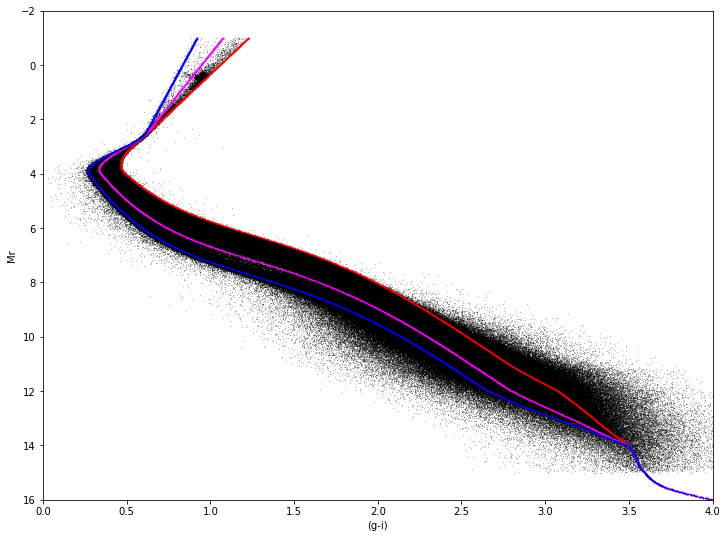

In [394]:
## last test before making output file...
fig,ax = plt.subplots(1,1,figsize=(12,9))

ax.set_xlim(0.0,4)
ax.set_ylim(16,-2) 

ax.set_xlabel('(g-i)')
ax.set_ylabel('Mr')

ax.scatter(tGood4sims['giObs0'], tGood4sims['Mr'], s=0.01, c='black') 
#ax.scatter(tGood4sims['giObs'], tGood4sims['Mr'], s=0.01, c='cyan')  

ax.scatter(LSSTlocus0['gi'], LSSTlocus0['Mr'], s=0.3, c='red')
ax.scatter(LSSTlocus1['gi'], LSSTlocus1['Mr'], s=0.3, c='magenta')
ax.scatter(LSSTlocus2['gi'], LSSTlocus2['Mr'], s=0.3, c='blue')

In [395]:
## 6) store in a data file 
# for Karlo: columns 14-23 with photometry
fout = open('../data/simCatalog_three_pix_triout_chiTest4.txt', "w")
fout.write("      glon       glat      comp   logg    FeH      Mr      DM      Ar ")
fout.write(" rmagObs0   ug0     gr0     ri0     iz0    rmag   ugObs   grObs   riObs   izObs")
fout.write("   uErr   gErr   rErr   iErr   zErr    ugSL    grSL    riSL    izSL")
fout.write(" ugErrSL grErrSL riErrSL izErrSL \n")
for i in range(0,np.size(tGood4sims)):
    # input values from TRILEGAL
    r1 = tGood4sims['glon'][i]
    r2 = tGood4sims['glat'][i]
    r3 = tGood4sims['comp'][i]
    r4 = tGood4sims['logg'][i]
    r5 = tGood4sims['FeH'][i]
    r6 = tGood4sims['Mr'][i]
    r7 = tGood4sims['DM'][i]
    r8 = tGood4sims['Ar'][i]  
    s = str("%12.8f " % r1) + str("%12.8f  " % r2) + str("%3.0f  " % r3) + str("%6.2f  " % r4)
    s = s + str("%5.2f  " % r5) + str("%6.2f  " % r6) + str("%6.2f  " % r7) + str("%6.3f  " % r8)  
    # observed colors, corrected for ISM extinction, same errors as for ugObs... below
    r1 = tGood4sims['rmagTLorig'][i]
    r2 = tGood4sims['ugObs0'][i] 
    r3 = tGood4sims['grObs0'][i] 
    r4 = tGood4sims['riObs0'][i] 
    r5 = tGood4sims['izObs0'][i] 
    s = s + str("%6.2f" % r1) + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # observed colors, with ISM extinction included
    r1 = tGood4sims['rmagObs'][i]
    r2 = tGood4sims['ugObs'][i] 
    r3 = tGood4sims['grObs'][i] 
    r4 = tGood4sims['riObs'][i] 
    r5 = tGood4sims['izObs'][i] 
    s = s + str("%8.2f" % r1) + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # errors for observed mags, generated from observed mags
    r1 = tGood4sims['umagErrObs'][i]
    r2 = tGood4sims['gmagErrObs'][i]
    r3 = tGood4sims['rmagErrObs'][i]
    r4 = tGood4sims['imagErrObs'][i]
    r5 = tGood4sims['zmagErrObs'][i]
    s = s + str("%7.3f" % r1) + str("%7.3f" % r2) + str("%7.3f" % r3) + str("%7.3f" % r4) + str("%7.3f" % r5)
    # true input values (ISM extinction included)
    r2 = tGood4sims['ugSL'][i] 
    r3 = tGood4sims['grSL'][i] 
    r4 = tGood4sims['riSL'][i] 
    r5 = tGood4sims['izSL'][i] 
    s = s + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    # true errors based on input mag values above
    r2 = tGood4sims['ugErrSL'][i] 
    r3 = tGood4sims['grErrSL'][i] 
    r4 = tGood4sims['riErrSL'][i] 
    r5 = tGood4sims['izErrSL'][i] 
    s = s + str("%8.3f" % r2) + str("%8.3f" % r3) + str("%8.3f" % r4) + str("%8.3f" % r5)
    s = s + "\n"
    fout.write(s)             
fout.close() 